# Image Segmentation with CAMVID Dataset

In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

from skimage.io import imread, imshow

from fastai.vision import get_image_files, open_image, open_mask, URLs, untar_data
from fastai.vision import get_transforms, error_rate, lr_find, unet_learner, defaults, imagenet_stats
from fastai.vision import models as vision_models
from fastai.vision import SegmentationItemList
from fastai.utils.mem import gpu_mem_get_free_no_cache

### Unloading data to OS default path

In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/codes.txt'),
 WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/images'),
 WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/labels'),
 WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/valid.txt')]

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

In [9]:
image_files = get_image_files(path_img)
image_files[:3]

[WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/images/0001TP_006750.png')]

In [10]:
label_files = get_image_files(path_lbl)
label_files[:3]

[WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('C:/Users/Milind Dalvi/.fastai/data/camvid/labels/0001TP_006750_P.png')]

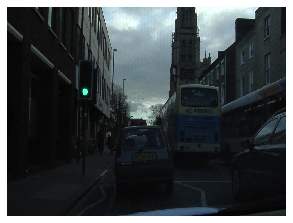

In [12]:
img = open_image(image_files[0])
img.show(figsize=(5,5))

In [14]:
# https://realpython.com/python-pathlib/

get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

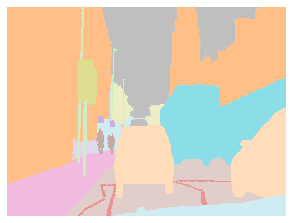

In [16]:
img = open_mask(get_y_fn(image_files[0]))
img.show(figsize=(5,5))

In [23]:
# Mask file peek

imread(get_y_fn(image_files[0]))

Array([[ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       [ 4,  4,  4,  4, ...,  4,  4,  4,  4],
       ...,
       [19, 19, 19, 19, ..., 30, 30, 30, 30],
       [19, 19, 19, 19, ..., 30, 30, 30, 30],
       [19, 19, 19, 19, ..., 30, 30, 30, 30],
       [19, 19, 19, 19, ..., 30, 30, 30, 30]], dtype=uint8)

In [24]:
# The targets are as per indics in codes

codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [26]:
valid = np.loadtxt(path/'valid.txt', dtype=str)
valid

array(['0016E5_07959.png', '0016E5_07961.png', '0016E5_07963.png', '0016E5_07965.png', ..., '0016E5_08153.png',
       '0016E5_08155.png', '0016E5_08157.png', '0016E5_08159.png'], dtype='<U16')

## Creating Dataset

In [25]:
free = gpu_mem_get_free_no_cache()
print(f"Using {free} MB of GPU RAM")

Using 0 MB of GPU RAM


In [27]:
data_source = (SegmentationItemList.from_folder(path_img).split_by_fname_file('../valid.txt').label_from_func(get_y_fn, classes=codes))
data_source

LabelLists;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\Milind Dalvi\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: C:\Users\Milind Dalvi\.fastai\data\camvid\images;

Test: None

In [31]:
bs = 8
size = 
dataset = (data_source.transform(get_transforms(), size=size, tfm_y=True).databunch(bs=bs).normalize(imagenet_stats))

In [32]:
data_source.train.x[0].shape

torch.Size([3, 720, 960])